In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Read Dataframe:   https://www.w3schools.com/python/pandas/pandas_csv.asp
df = pd.read_csv('Data/GPRO_Data.csv')
df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize('America/New_York')
price_column = df['close']

# Normalize Data:   https://www.geeksforgeeks.org/what-is-data-normalization/
unchanged_stock_prices = price_column.to_numpy() 
stock_prices = (unchanged_stock_prices - np.min(unchanged_stock_prices)) / (np.max(unchanged_stock_prices) - np.min(unchanged_stock_prices))


# Convert to PyTorch tensors and reshape for LSTM
# Model Example:    https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/
sequence_length = 180
x_train, y_train = [], []

for iter in range(len(stock_prices) - sequence_length):
    # Continues until no data is left
    # Generates input and target values
    x_train.append(stock_prices[iter:iter + sequence_length])
    y_train.append(stock_prices[iter + sequence_length])

# Reshape for LSTM
# Tensor:   https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
x_train = torch.tensor(x_train, dtype=torch.float32).view(-1, sequence_length, 1)  
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

In [2]:
# Define LSTM:  https://www.geeksforgeeks.org/long-short-term-memory-networks-using-pytorch/
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Create hidden layer and cell layer
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) 
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Fully connected layer 
        out = self.fc(out[:, -1, :])  
        return out

In [3]:
# Initialize model, loss, and optimizer
input_size = 1        # Each week has 1 stock price
hidden_size = 180      # Number of LSTM units
output_size = 1       # Predicting 1 stock price
num_layers = 2        # Double LSTM layer
learning_rate = 0.001
num_epochs = 100

# Create object
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
# Optimizer:    https://www.geeksforgeeks.org/adam-optimizer/
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
for epoch in range(num_epochs):
    # Train Model
    # How Epochs Work:  https://deepai.org/machine-learning-glossary-and-terms/epoch
    model.train()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Calculate MAE and RMSE for training data
    if (epoch + 1) % 10 == 0:
        # MAE:              https://www.geeksforgeeks.org/how-to-calculate-mean-absolute-error-in-python/
        # Tensor.detach():  https://www.geeksforgeeks.org/tensor-detach-method-in-python-pytorch/
        mae = mean_absolute_error(y_train.detach().numpy(), outputs.detach().numpy())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, MAE: {mae:.4f}')

Epoch [10/100], Loss: 0.0213, MAE: 0.1274
Epoch [20/100], Loss: 0.0142, MAE: 0.1064
Epoch [30/100], Loss: 0.0218, MAE: 0.1113
Epoch [40/100], Loss: 0.0160, MAE: 0.1101
Epoch [50/100], Loss: 0.0166, MAE: 0.1156
Epoch [60/100], Loss: 0.0134, MAE: 0.1013
Epoch [70/100], Loss: 0.0054, MAE: 0.0638
Epoch [80/100], Loss: 0.0020, MAE: 0.0325
Epoch [90/100], Loss: 0.0018, MAE: 0.0330
Epoch [100/100], Loss: 0.0015, MAE: 0.0279


In [5]:
# Predictions into October 2024
# Switch to Eval mode
model.eval()
# Number of days in October you want to predict
future_steps = 23 
# Start with last sequence 
predicted_prices = stock_prices[-sequence_length:].tolist()


In [6]:
# Model predicts one step at a time
for blank in range(future_steps):
    input_seq = torch.tensor(predicted_prices[-sequence_length:], dtype=torch.float32).view(1, sequence_length, 1)
    next_price = model(input_seq).item()
    predicted_prices.append(next_price)

# Transform predictions back to original scale (Unnormalize):   https://www.geeksforgeeks.org/what-is-data-normalization/
predicted_prices = np.array(predicted_prices[-future_steps:])
predicted_prices = np.round(predicted_prices * (np.max(unchanged_stock_prices) - np.min(unchanged_stock_prices)) + np.min(unchanged_stock_prices), 2)

# Read actual prices
oct_df = pd.read_csv('Data/GPRO_October_2024_Data.csv')
oct_df['Date'] = pd.to_datetime(oct_df['Date']).dt.tz_localize('America/New_York')
actual_prices = oct_df['close'].to_numpy()

# Calculate final MAE and RMSE for October predictions
final_mae = mean_absolute_error(actual_prices, predicted_prices)
final_rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f'October Predictions - MAE: {final_mae:.2f}, RMSE: {final_rmse:.2f}')

# Prepare the results DataFrame for October 2024 dates
october_dates = pd.date_range(start='2024-10-01', periods=future_steps, freq='B', tz='UTC')  # 'B' frequency only includes weekdays
october_predictions = pd.DataFrame({'Date': october_dates, 'Predicted': predicted_prices})
october_predictions['Date'] = pd.to_datetime(october_predictions['Date']).dt.tz_convert('America/New_York')

# Save results
october_predictions.to_csv('Results/october_GPRO_predictions.csv', index=False)


October Predictions - MAE: 0.13, RMSE: 0.15


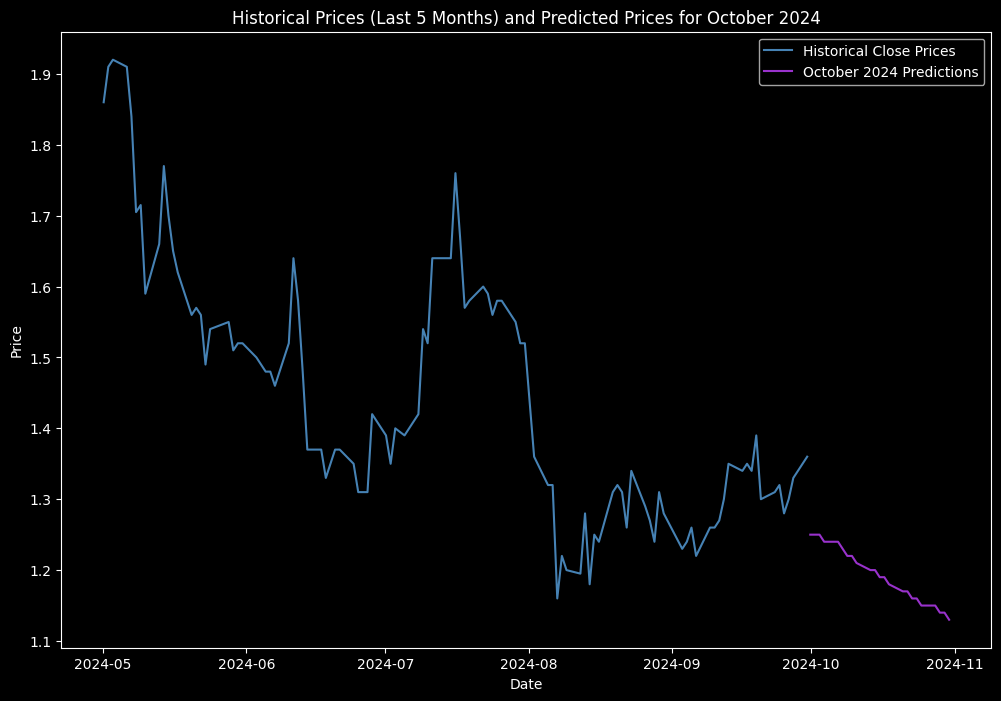

In [7]:
# Dates
last_date = october_predictions['Date'].min()
start_date = last_date - pd.DateOffset(months=5)
filtered_df = df[df['Date'] >= start_date]

# Dark mode
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))

# Plot the last 5 months of historical data
plt.plot(filtered_df['Date'], filtered_df['close'], label='Historical Close Prices', color='steelblue')

# Plot the October 2024 predictions
plt.plot(october_predictions['Date'], october_predictions['Predicted'], label='October 2024 Predictions', color='darkorchid')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical Prices (Last 5 Months) and Predicted Prices for October 2024')
plt.legend()

# Display the plot
plt.show()